In [1]:
## Imports
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would 
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

In [3]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [4]:
## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

In [5]:
## Some constants that we deem given (maybe periodically update)
stakedETHamount = 34385053 ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking 
noOfValidators = 1074533 ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659*math.sqrt(noOfValidators) ## the constant is coming from epochs per year (roughly)
APR = 2940.21/math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14 # weights page 100
W_t = 26
W_h = 14
W_y = 3 ## sync reward weight
W_p = 12.5 ## proposer weight
W_Sigma = 64 ## defined at page 109
T = stakedETHamount ## defined at page 102
n = 32 ## number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64 ## https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000*base_reward_factor)/math.sqrt(32000000000*noOfValidators) ## base reward per increment
## Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625*T*b ## page 107
wrong_source_attestation = (-W_s-W_t)/W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1/32 ##defined at page 116
## correlation penalty page 117
## other penalties

In [6]:
## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation 

In [7]:
print(maxIssuancePerYear,"ETH issued per year")
print(APR,"% APR")

975298.6148563978 ETH issued per year
2.8364064971488903 % APR


In [8]:
print(base_reward_factor)

64


In [9]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659*math.sqrt(noOfValidators)

In [10]:
def getAPR(noOfValidators):
    return 2940.21/math.sqrt(noOfValidators)

In [14]:
nowValidators = 1074533
noOfBribedValidators = 300000
oneYearRewards = [32*getAPR(i)/100 for i in range(nowValidators,nowValidators-noOfBribedValidators,-1)]
bribeAmounts = [sum(oneYearRewards[:i]) for i in range(len(oneYearRewards))]

<>:2: SyntaxWarning: invalid escape sequence '\#'
<>:2: SyntaxWarning: invalid escape sequence '\#'
/var/folders/fb/05k260gx67s5jxx5m1hfs7400000gn/T/ipykernel_5405/2351514803.py:2: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$Bribed Validators")


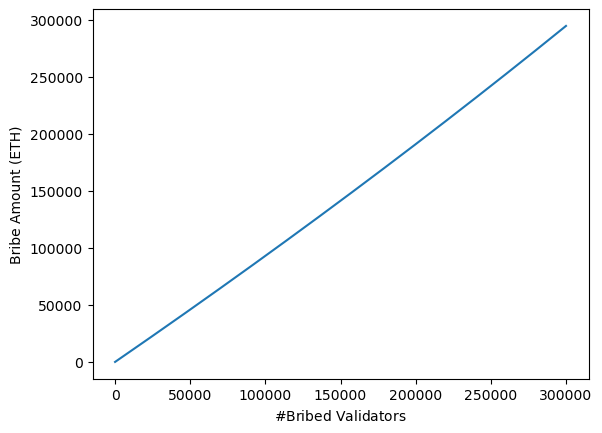

In [15]:
plt.plot(bribeAmounts)
plt.xlabel("$\#$Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

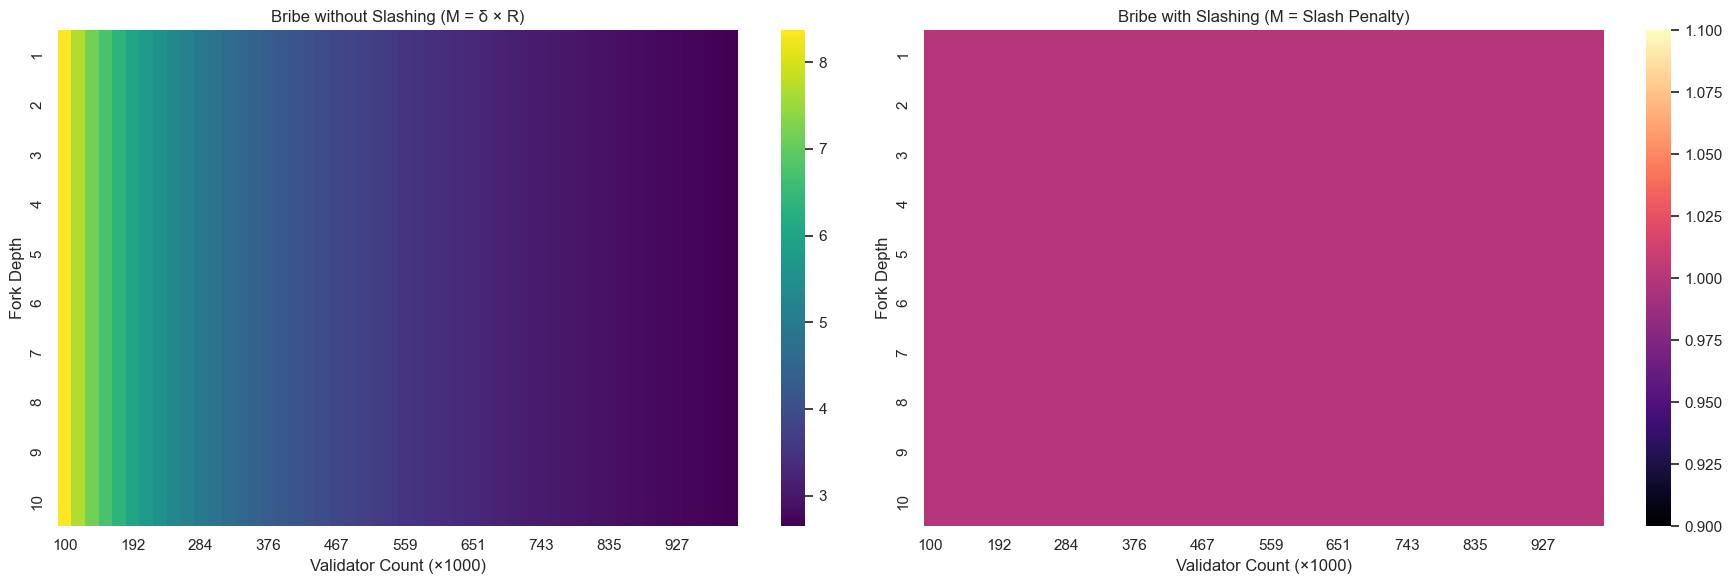

In [8]:
delta = 0.9               # time discount factor
k = 2940.21               # reward constant, approx.
slash_fraction = 1 / 32   # base slashing penalty (simplified)
base_stake = 32           # ETH per validator

def honest_reward(N):
    return k / np.sqrt(N)

def slash_penalty():
    return slash_fraction * base_stake

validator_range = np.linspace(100_000, 1_000_000, 50)
fork_depth_range = np.arange(1, 11)  # from 1 to 10 blocks deep
X, Y = np.meshgrid(validator_range, fork_depth_range)

reward_grid = delta * honest_reward(X)
slashing_grid = slash_penalty() * np.ones_like(X)  # constant

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(reward_grid, ax=axs[0], xticklabels=5, yticklabels=1, cmap='viridis')
axs[0].set_title('Bribe without Slashing (M = δ × R)')
axs[0].set_xlabel('Validator Count (×1000)')
axs[0].set_ylabel('Fork Depth')
axs[0].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[0].set_yticklabels(fork_depth_range)

sns.heatmap(slashing_grid, ax=axs[1], xticklabels=5, yticklabels=1, cmap='magma')
axs[1].set_title('Bribe with Slashing (M = Slash Penalty)')
axs[1].set_xlabel('Validator Count (×1000)')
axs[1].set_ylabel('Fork Depth')
axs[1].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[1].set_yticklabels(fork_depth_range)

plt.tight_layout()
plt.show()

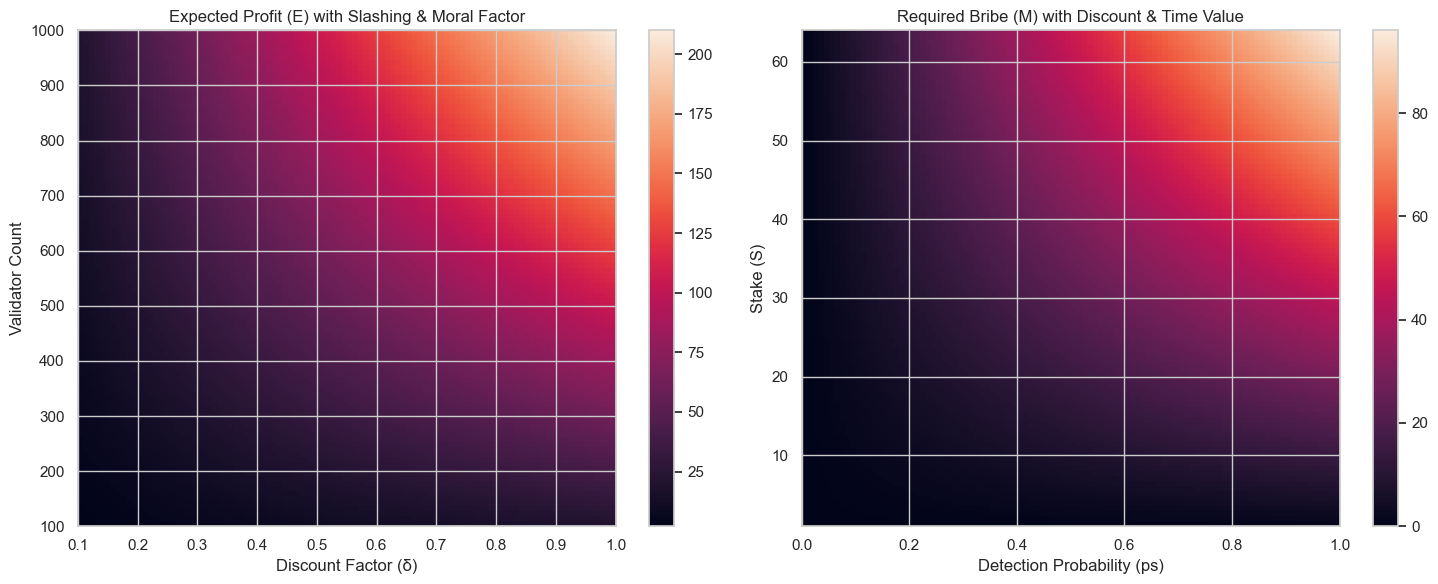

In [9]:
validator_count_range = np.linspace(100, 1000, 100)
delta_range = np.linspace(0.1, 1, 100)
ps_range = np.linspace(0, 1, 100)
stake_range = np.linspace(1, 64, 100)

def generate_dynamic_heatmaps(alpha=0.5, ps=0.5, delta=0.9, time_value=0.1):
    X1, Y1 = np.meshgrid(delta_range, validator_count_range)
    expected_profit = X1 * Y1 * (1 - ps) * (1 - alpha)

    X2, Y2 = np.meshgrid(ps_range, stake_range)
    required_bribe = X2 * Y2 * (1 + time_value) / delta

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    im1 = axs[0].imshow(expected_profit, aspect='auto', origin='lower',
                        extent=[delta_range.min(), delta_range.max(), validator_count_range.min(), validator_count_range.max()])
    axs[0].set_title("Expected Profit (E) with Slashing & Moral Factor")
    axs[0].set_xlabel("Discount Factor (δ)")
    axs[0].set_ylabel("Validator Count")
    fig.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(required_bribe, aspect='auto', origin='lower',
                        extent=[ps_range.min(), ps_range.max(), stake_range.min(), stake_range.max()])
    axs[1].set_title("Required Bribe (M) with Discount & Time Value")
    axs[1].set_xlabel("Detection Probability (ps)")
    axs[1].set_ylabel("Stake (S)")
    fig.colorbar(im2, ax=axs[1])

    plt.tight_layout()
    plt.show()

generate_dynamic_heatmaps(alpha=0.3, ps=0.7, delta=0.8, time_value=0.2)

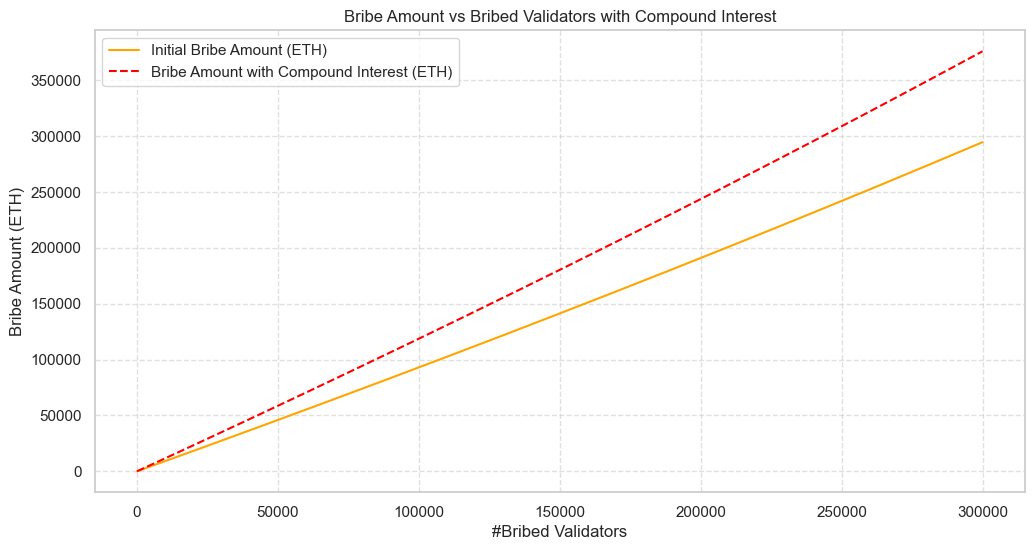

In [10]:
stakedETHAmount = 34385053             # Total staked ETH (2025.04.01)
noOfValidators = 1074533               # Number of validators (2025.04.01)
noOfBribedValidators = 300000          # Number of bribed validators

def getAPR(noOfValidators):
    return 2940.21 / np.sqrt(noOfValidators)

oneYearRewards = [32 * getAPR(i) / 100 for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)]
bribeAmounts = np.cumsum(oneYearRewards)  

interest_rate = 0.05  # 5% annual interest rate
years = 5 

bribeWithInterest = bribeAmounts * (1 + interest_rate) ** years

plt.figure(figsize=(12, 6))
plt.plot(bribeAmounts, label="Initial Bribe Amount (ETH)", color='orange')
plt.plot(bribeWithInterest, label="Bribe Amount with Compound Interest (ETH)", linestyle="--", color='red')
plt.xlabel("#Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.title("Bribe Amount vs Bribed Validators with Compound Interest")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [11]:
num_validators = 1000
delta_values = np.linspace(0.0, 1.0, 5) 
alpha_values = np.linspace(0.1, 0.5, 5)      
ps_values = np.linspace(0.5, 1.0, 5) 

results = []

for delta in delta_values:
    for alpha in alpha_values:
        for ps in ps_values:
            bribe_offer = alpha * ps
            honest_reward = 1.0
            punished_reward = (1 - delta) * honest_reward

            bribed = 0
            for _ in range(num_validators):
                if bribe_offer > punished_reward:
                    bribed += 1

            bribed_ratio = bribed / num_validators
            system_collapse = bribed_ratio > 0.33 

            results.append({
                'delta': round(delta, 2),
                'alpha': round(alpha, 2),
                'ps': round(ps, 2),
                'bribed_ratio': round(bribed_ratio, 2),
                'system_collapse': system_collapse})

df = pd.DataFrame(results)
print(df)

collapsed = df[df['system_collapse'] == True]
print("\nCases where the system collapses:")
print(collapsed)

     delta  alpha    ps  bribed_ratio  system_collapse
0      0.0    0.1  0.50           0.0            False
1      0.0    0.1  0.62           0.0            False
2      0.0    0.1  0.75           0.0            False
3      0.0    0.1  0.88           0.0            False
4      0.0    0.1  1.00           0.0            False
..     ...    ...   ...           ...              ...
120    1.0    0.5  0.50           1.0             True
121    1.0    0.5  0.62           1.0             True
122    1.0    0.5  0.75           1.0             True
123    1.0    0.5  0.88           1.0             True
124    1.0    0.5  1.00           1.0             True

[125 rows x 5 columns]

Cases where the system collapses:
     delta  alpha    ps  bribed_ratio  system_collapse
88    0.75    0.3  0.88           1.0             True
89    0.75    0.3  1.00           1.0             True
92    0.75    0.4  0.75           1.0             True
93    0.75    0.4  0.88           1.0             True
94    

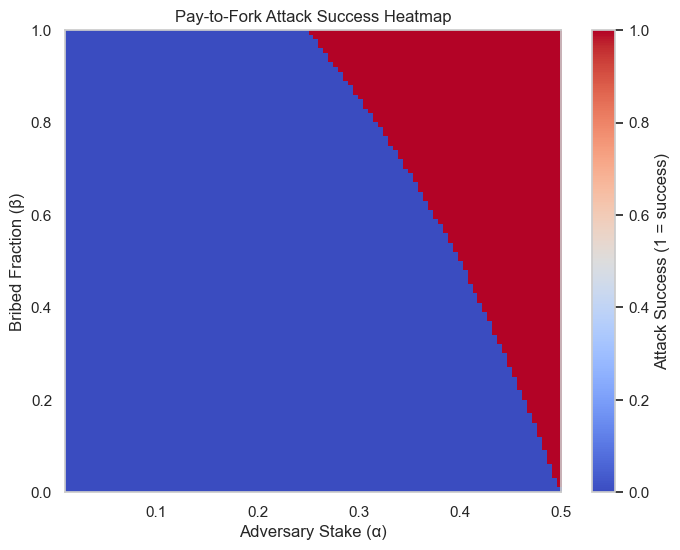

In [15]:
alpha_vals = np.linspace(0.01, 0.5, 100)  # adversary stake
beta_vals = np.linspace(0, 1, 100)        # bribed fraction

F = 1  # fork chain reward
D = 2  # canonical chain reward

success_matrix = np.zeros((len(beta_vals), len(alpha_vals)))

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):
        lhs = F * (1 - beta) * (1 - alpha) + D * (1 - alpha)
        rhs = D * alpha + F * alpha + F * beta * (1 - alpha)
        success_matrix[i, j] = 1 if lhs < rhs else 0  # 1 = succes


plt.figure(figsize=(8, 6))
plt.imshow(success_matrix, extent=[alpha_vals[0], alpha_vals[-1], beta_vals[0], beta_vals[-1]],
           origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Attack Success (1 = success)')
plt.xlabel('Adversary Stake (α)')
plt.ylabel('Bribed Fraction (β)')
plt.title('Pay-to-Fork Attack Success Heatmap')
plt.grid(False)
plt.show()

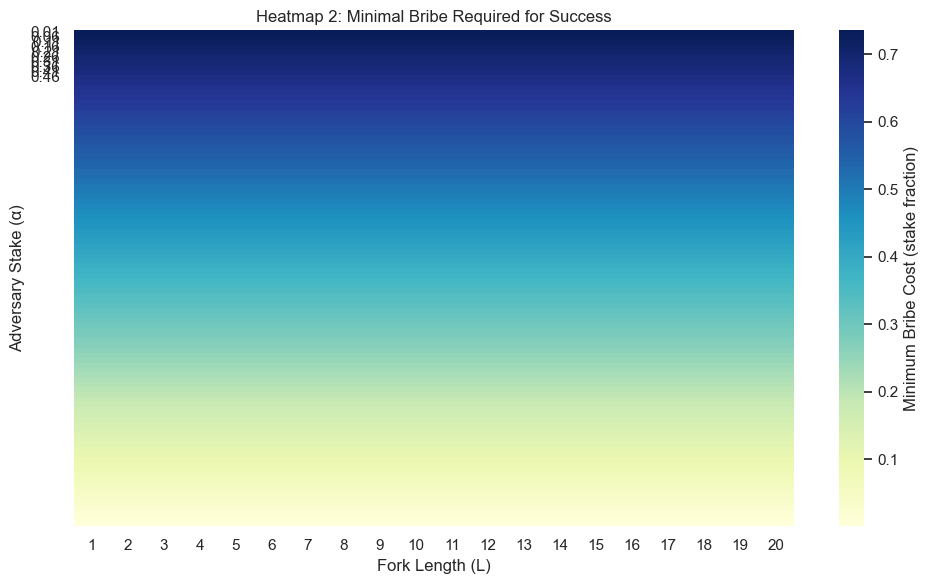

In [16]:
F = 2  
D = 1 

fork_lengths = np.arange(1, 21)  
alpha_vals = np.linspace(0.01, 0.5, 100)  

success_matrix = np.zeros((len(alpha_vals), len(fork_lengths)))

for i, alpha in enumerate(alpha_vals):
    for j, L in enumerate(fork_lengths):
        beta = 1
        lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * L
        rhs = D * alpha * L + F * alpha * L + F * beta * (1 - alpha) * L
        success_matrix[i, j] = 1 if lhs < rhs else 0

bribe_cost_matrix = np.zeros((len(alpha_vals), len(fork_lengths)))

for i, alpha in enumerate(alpha_vals):
    for j, L in enumerate(fork_lengths):
        found = False
        for beta in np.linspace(0, 1, 1000):
            lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * L
            rhs = D * alpha * L + F * alpha * L + F * beta * (1 - alpha) * L
            if lhs < rhs:
                bribe_cost_matrix[i, j] = beta * (1 - alpha)
                found = True
                break
        if not found:
            bribe_cost_matrix[i, j] = np.nan 


#plt.figure(figsize=(10, 6))
#sns.heatmap(success_matrix, xticklabels=fork_lengths, yticklabels=np.round(alpha_vals, 2)[::10],
#            cmap='coolwarm', cbar_kws={'label': 'Attack Success (1 = success)'})
#plt.xlabel("Fork Length (L)")
#plt.ylabel("Adversary Stake (α)")
#plt.title("Heatmap 1: Success of Pay-to-Fork Attack")
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(bribe_cost_matrix, xticklabels=fork_lengths, yticklabels=np.round(alpha_vals, 2)[::10],
            cmap='YlGnBu', cbar_kws={'label': 'Minimum Bribe Cost (stake fraction)'})
plt.xlabel("Fork Length (L)")
plt.ylabel("Adversary Stake (α)")
plt.title("Heatmap 2: Minimal Bribe Required for Success")
plt.tight_layout()
plt.show()


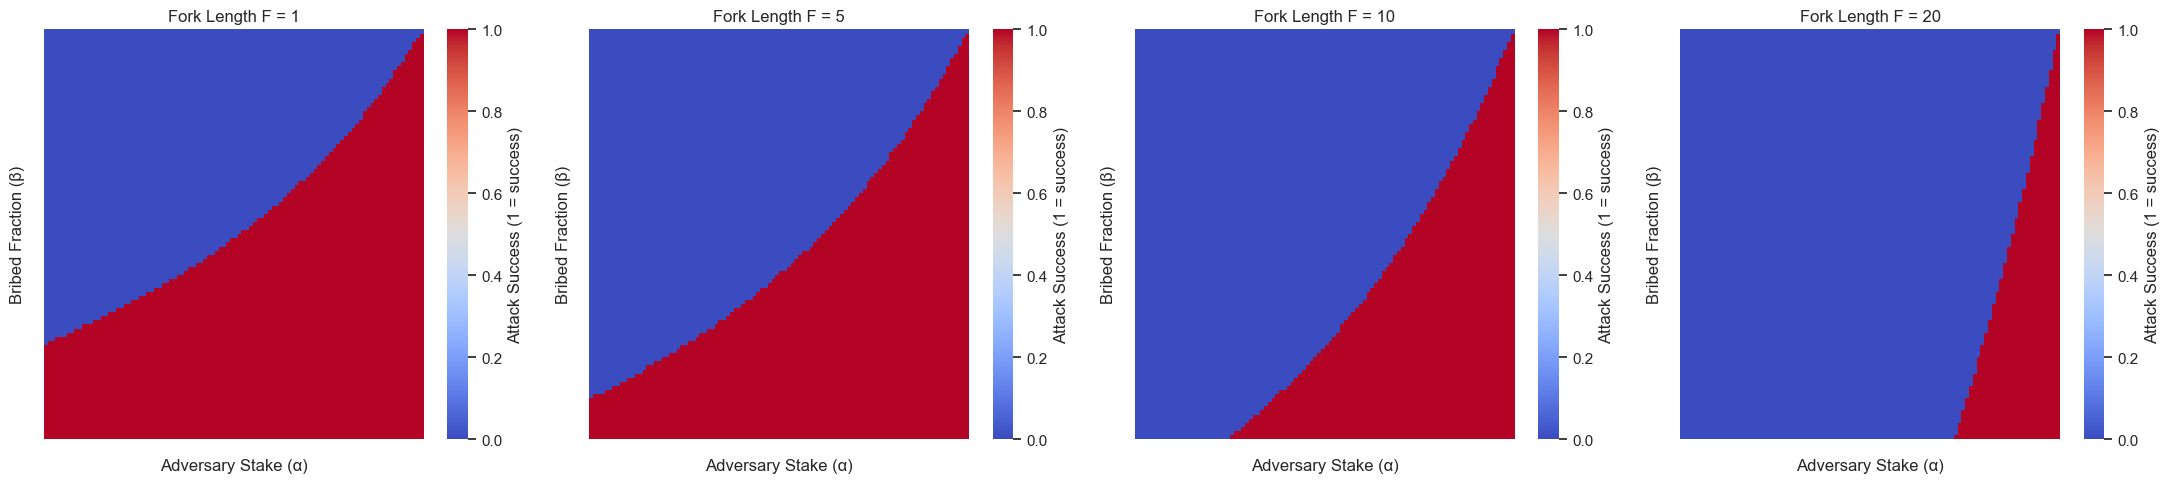

In [17]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)
fork_lengths = [1, 5, 10, 20]

F0 = 2
D = 1
k = 0.1

heatmaps = []

for L in fork_lengths:
    F = F0 * np.exp(-k * L)
    matrix = np.zeros((len(beta_vals), len(alpha_vals)))

    for i, beta in enumerate(beta_vals):
        for j, alpha in enumerate(alpha_vals):
            lhs = F * (1 - beta) * (1 - alpha) + D * (1 - alpha)
            rhs = D * alpha + F * alpha + F * beta * (1 - alpha)
            matrix[i, j] = 1 if lhs < rhs else 0

    heatmaps.append(matrix)

fig, axs = plt.subplots(1, len(fork_lengths), figsize=(22, 5))

xticks_idx = np.linspace(0, len(alpha_vals)-1, 6, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals)-1, 6, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx, ax in enumerate(axs):
    sns.heatmap(
        heatmaps[idx],
        xticklabels=xticks,
        yticklabels=yticks,
        cmap='coolwarm',
        cbar_kws={'label': 'Attack Success (1 = success)'},
        ax=ax
    )
    ax.set_title(f"Fork Length F = {fork_lengths[idx]}")
    ax.set_xlabel("Adversary Stake (α)")
    ax.set_ylabel("Bribed Fraction (β)")
    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

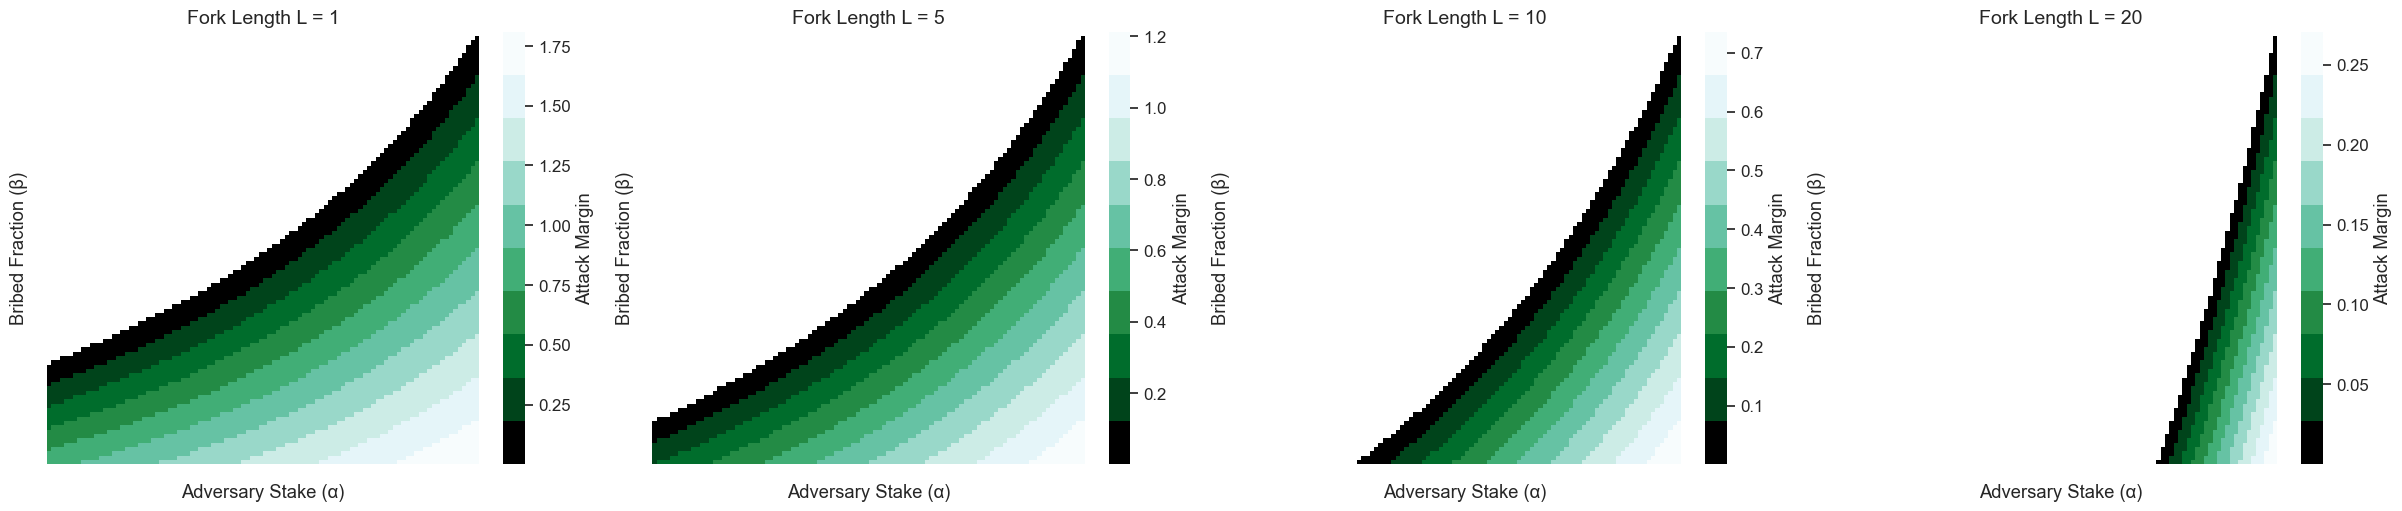

In [18]:
from matplotlib.colors import ListedColormap

alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)
fork_lengths = [1, 5, 10, 20]

F0 = 2
D = 1
k = 0.1

colors = ["black", "#00441b", "#006d2c", "#238b45", "#41ae76",
          "#66c2a4", "#99d8c9", "#ccece6", "#e5f5f9", "#f7fcfd"]
cmap = ListedColormap(colors)

heatmaps = []

for L in fork_lengths:
    F = F0 * np.exp(-k * L)
    matrix = np.full((len(beta_vals), len(alpha_vals)), np.nan)

    for i, beta in enumerate(beta_vals):
        for j, alpha in enumerate(alpha_vals):
            lhs = F * (1 - beta) * (1 - alpha) + D * (1 - alpha)
            rhs = D * alpha + F * alpha + F * beta * (1 - alpha)
            if lhs < rhs:
              matrix[i, j] = rhs - lhs

    heatmaps.append(matrix)

sns.set(style="white", font_scale=1.1)
fig, axs = plt.subplots(1, len(fork_lengths), figsize=(24, 5), constrained_layout=True)

xticks_idx = np.linspace(0, len(alpha_vals)-1, 6, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals)-1, 6, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx, ax in enumerate(axs):
    sns.heatmap(
        heatmaps[idx],
        cmap=cmap,
        mask=np.isnan(heatmaps[idx]),
        xticklabels=xticks,
        yticklabels=yticks,
        cbar_kws={'label': 'Attack Margin'},
        square=True,
        ax=ax
    )
    ax.set_title(f"Fork Length L = {fork_lengths[idx]}", fontsize=14)
    ax.set_xlabel("Adversary Stake (α)")
    ax.set_ylabel("Bribed Fraction (β)")
    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.tick_params(axis='x', rotation=45)

plt.show()

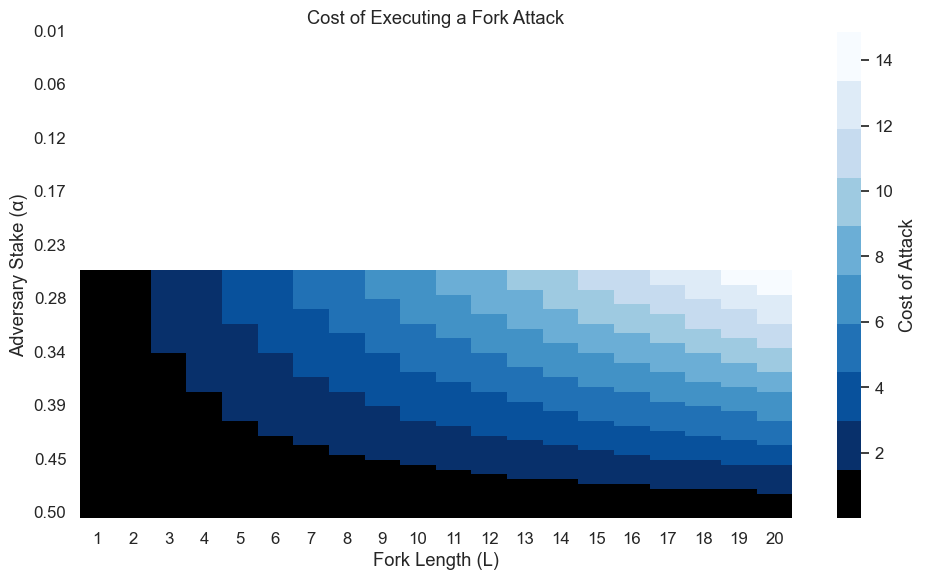

In [19]:
fork_lengths = np.arange(1, 21)               # fork hossza
alpha_vals = np.linspace(0.01, 0.5, 100)      # adversary stake

F = 1       # reward on the fork
D = 2       # reward on canonical chain
unit_cost = 1  # cost per unit bribed stake

cost_matrix = np.full((len(alpha_vals), len(fork_lengths)), np.nan)

for i, alpha in enumerate(alpha_vals):
    for j, L in enumerate(fork_lengths):
        betas = np.linspace(0, 1, 1000)
        for beta in betas:
            lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * L
            rhs = D * alpha * L + F * alpha * L + F * beta * (1 - alpha) * L
            if lhs < rhs:
                cost_matrix[i, j] = beta * (1 - alpha) * unit_cost * L
                break

colors = ["black", "#08306b", "#08519c", "#2171b5", "#4292c6",
          "#6baed6", "#9ecae1", "#c6dbef", "#deebf7", "#f7fbff"]
cmap = ListedColormap(colors)



plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    cost_matrix,
    xticklabels=fork_lengths,
    cmap=cmap,
    mask=np.isnan(cost_matrix),
    cbar_kws={'label': 'Cost of Attack'})

ytick_indices = np.linspace(0, len(alpha_vals) - 1, 10, dtype=int)
ytick_labels = [f"{alpha_vals[i]:.2f}" for i in ytick_indices]
ax.set_yticks(ytick_indices)
ax.set_yticklabels(ytick_labels)

plt.xlabel("Fork Length (L)")
plt.ylabel("Adversary Stake (α)")
plt.title("Cost of Executing a Fork Attack")
plt.tight_layout()
plt.show()